In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**First we'll be importing all the necessary libraries**

In [2]:
#pip install tensorflow==2.5

In [3]:
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**Reading the datasets from the directory**

In [4]:
data = pd.read_csv("/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv")
data.head(20)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg
5,6,60,Male,6_left.jpg,6_right.jpg,macular epiretinal membrane,moderate non proliferative retinopathy，epireti...,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",6_right.jpg
6,7,60,Female,7_left.jpg,7_right.jpg,drusen,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",7_right.jpg
7,8,59,Male,8_left.jpg,8_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",8_right.jpg
8,9,54,Male,9_left.jpg,9_right.jpg,normal fundus,vitreous degeneration,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",9_right.jpg
9,10,70,Male,10_left.jpg,10_right.jpg,epiretinal membrane,normal fundus,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",10_right.jpg


In [5]:
def has_condn(term,text):
    if term in text:
        return 1
    else:
        return 0

Attaching labels based whether cataract is present on which eye (left/right)

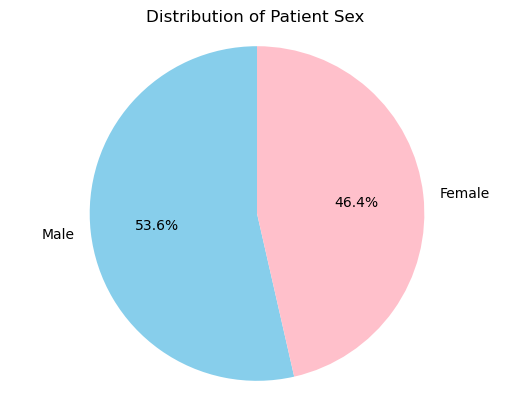

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

gender_counts = data['Patient Sex'].value_counts()
colors=['skyblue','pink']
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90,colors=colors)

plt.title('Distribution of Patient Sex ')

plt.axis('equal')
plt.show()


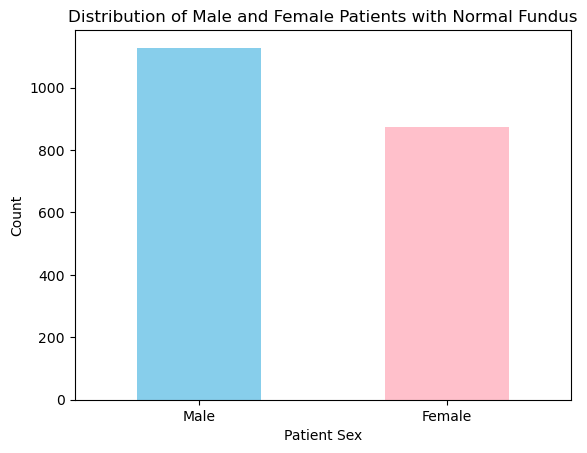

In [7]:
filtered_data = data[(data['Left-Diagnostic Keywords'] == 'normal fundus') & (data['Right-Diagnostic Keywords'] == 'normal fundus')]

gender_counts = filtered_data['Patient Sex'].value_counts()
colors=['skyblue','pink']
gender_counts.plot(kind='bar', rot=0,color=colors)

plt.xlabel('Patient Sex')
plt.ylabel('Count')
plt.title('Distribution of Male and Female Patients with Normal Fundus')

plt.show()

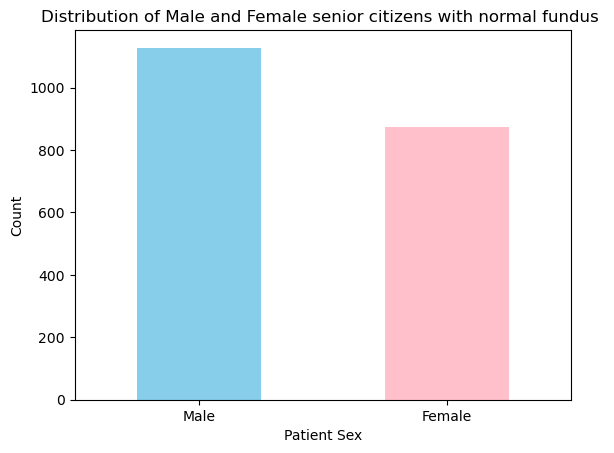

In [8]:
senior_citizens = data[(data['Left-Diagnostic Keywords'] == 'normal fundus') & (data['Right-Diagnostic Keywords'] == 'normal fundus') &(data['Patient Age'] >= 65)]
colors=['skyblue','pink']
gender_counts.plot(kind='bar', rot=0,color=colors)

plt.xlabel('Patient Sex')
plt.ylabel('Count')
plt.title('Distribution of Male and Female senior citizens with normal fundus ')
plt.show()

In [9]:


#data[data.O==1].head(20)  #drusen or epiretinal membrane

def process_dataset(data):
    #create 2 more columns labelling them whether right or left cataract
    data["left_cataract"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("cataract",x))
    data["right_cataract"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("cataract",x))
  
    data["LD"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("non proliferative retinopathy",x))
    data["RD"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("non proliferative retinopathy",x))

    data["LG"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("glaucoma",x))
    data["RG"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("glaucoma",x))
    
    data["LH"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("hypertensive",x))
    data["RH"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("hypertensive",x))

    data["LM"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("myopia",x))
    data["RM"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("myopia",x))
    
    data["LA"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("macular degeneration",x))
    data["RA"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("macular degeneration",x))
    
    data["LO"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("drusen",x))
    data["RO"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("drusen",x))
    
    #store the right/left cataract images ids in a array
    left_cataract_images = data.loc[(data.C ==1) & (data.left_cataract == 1)]["Left-Fundus"].values
    right_cataract_images = data.loc[(data.C == 1) & (data.right_cataract == 1)]["Right-Fundus"].values
  
    #store the left/right normal image ids in a array
    left_normal = data.loc[(data.C == 0) & (data["Left-Diagnostic Keywords"] == "normal fundus")]['Left-Fundus'].sample(350,random_state=42).values
    right_normal = data.loc[(data.C == 0) & (data["Right-Diagnostic Keywords"] == "normal fundus")]['Right-Fundus'].sample(350,random_state=42).values
    
    #store the left/right diabetes image ids
    left_diab = data.loc[(data.C == 0) & (data.LD == 1)]["Left-Fundus"].values
    right_diab = data.loc[(data.C == 0) & (data.RD == 1)]["Right-Fundus"].values 

    #store the left/right glaucoma image ids
    left_glaucoma = data.loc[(data.C == 0) & (data.LG == 1)]["Left-Fundus"].values
    right_glaucoma = data.loc[(data.C == 0) & (data.RG == 1)]["Right-Fundus"].values 
    
    #store the left/right diabetes image ids
    left_hyper = data.loc[(data.C == 0) & (data.LH == 1)]["Left-Fundus"].values
    right_hyper = data.loc[(data.C == 0) & (data.RH == 1)]["Right-Fundus"].values 
    
    #store the left/right diabetes image ids
    left_myopia = data.loc[(data.C == 0) & (data.LM == 1)]["Left-Fundus"].values
    right_myopia = data.loc[(data.C == 0) & (data.RM == 1)]["Right-Fundus"].values 
    
    #store the left/right diabetes image ids
    left_age = data.loc[(data.C == 0) & (data.LA == 1)]["Left-Fundus"].values
    right_age = data.loc[(data.C == 0) & (data.RA == 1)]["Right-Fundus"].values 
    
    #store the left/right diabetes image ids
    left_other = data.loc[(data.C == 0) & (data.LO == 1)]["Left-Fundus"].values
    right_other = data.loc[(data.C == 0) & (data.RO == 1)]["Right-Fundus"].values 
    
    normalones = np.concatenate((left_normal,right_normal),axis = 0);
    cataractones = np.concatenate((left_cataract_images,right_cataract_images),axis = 0);
    diabones = np.concatenate((left_diab,right_diab),axis = 0);
    glaucoma = np.concatenate((left_glaucoma,right_glaucoma),axis = 0);
    hyper = np.concatenate((left_hyper,right_hyper),axis = 0);
    myopia = np.concatenate((left_myopia,right_myopia),axis = 0);
    age = np.concatenate((left_age,right_age),axis=0);
    other = np.concatenate((left_other,right_other),axis = 0);
    
    return normalones,cataractones,diabones,glaucoma,hyper,myopia,age,other;

In [10]:
normal , cataract , diab, glaucoma , hyper , myopia , age, other = process_dataset(data);

print("Dataset stats::")
print("Normal ::" , len(normal))
print("Cataract ::" , len(cataract))
print("Diabetes ::" , len(diab))
print("Glaucoma ::" , len(glaucoma))
print("Hypertension ::" , len(hyper))
print("Myopia ::" , len(myopia))
print("Age Issues ::" , len(age))
print("Other ::" , len(other))



Dataset stats::
Normal :: 700
Cataract :: 594
Diabetes :: 1818
Glaucoma :: 610
Hypertension :: 374
Myopia :: 479
Age Issues :: 551
Other :: 324


In [11]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = "/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images"
image_size=224
labels = []
dataset = []
def dataset_generator(imagecategory , label):
    for img in tqdm(imagecategory):
        imgpath = os.path.join(dataset_dir,img);
        
        #now we try to read the image and resize it accordingly
        try:
            image = cv2.imread(imgpath,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue;
        dataset.append([np.array(image),np.array(label)]);
    random.shuffle(dataset);
    
    return dataset;

Generating Dataset

In [12]:
# Normal == 0
# Cataract == 1
# Diabetes == 2
# Glaucoma == 3
# HyperTension == 4
# Myopia == 5
# Age == 6
# Other == 7

dataset = dataset_generator(normal,0)
dataset = dataset_generator(cataract,1)
dataset = dataset_generator(diab,2)
dataset = dataset_generator(glaucoma,3)
dataset = dataset_generator(hyper,4)
dataset = dataset_generator(myopia,5)
dataset = dataset_generator(age,6)
dataset = dataset_generator(other,7)

len(dataset)


100%|██████████| 324/324 [00:02<00:00, 131.51it/s]


5396

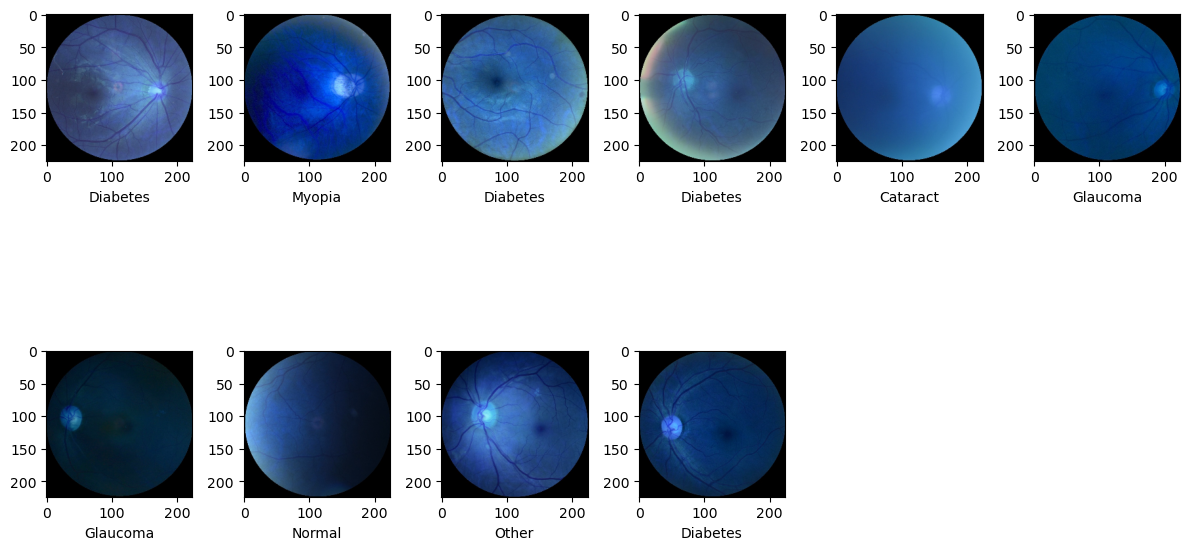

In [13]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    
    if category== 0:
        label = "Normal"
    elif category == 1 :
        label = "Cataract"
    elif category == 2:
        label = "Diabetes"
    elif category == 3:
        label = "Glaucoma"
    elif category == 4:
        label = "Hypertension"
    elif category == 5:
        label = "Myopia"
    elif category == 6:
        label = "Age Issues"
    else:
        label = "Other"
           
    plt.subplot(2,6,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()    

In [14]:
#Divide the dataset into 2 predictors and target...
#here predictors would be the image and target would be the label

train_x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3);
train_y = np.array([i[1] for i in dataset])

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
#splitting the dataset
x_train , x_test , y_train, y_test = train_test_split(train_x,train_y, test_size=0.2)

y_train_cat = to_categorical(y_train,num_classes=8)

y_test_cat = to_categorical(y_test,num_classes = 8)


Creating the Model

In [15]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Import libraries
import json
import os
import pickle
import random
import time

# Ignore warnings
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

# PyTorch model
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from skimage import io, transform

In [16]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [17]:
!nvidia-smi

Tue Apr 30 21:36:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [18]:
device_name = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)

print(device_name)

cuda


In [19]:
def save_checkpoint(state, is_best, filename='/kaggle/working/bt_resnet50_ckpt_v2.pth.tar'):
    torch.save(state, filename)

In [20]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import models
from tensorflow.keras import layers

# Instantiate ResNet50 model
resnet_model = ResNet50(weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3))

# Set all parameters as trainable
for layer in resnet_model.layers:
    layer.trainable = True

# Get the number of input features for the fc layer
n_inputs = resnet_model.output_shape[1]

# Redefine fc layer for the classification problem
resnet_model_top = models.Sequential([
    layers.Flatten(),
    layers.Dense(2048, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(2048, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(8, activation="softmax")
])

# Concatenate ResNet50 base model with the new top layers
model = models.Sequential([
    resnet_model,
    resnet_model_top
])

# Print model summary
model.summary()


94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 sequential (Sequential)     (None, 8)                 209735688 
                                                                 
Total params: 233,323,400
Trainable params: 233,270,280
Non-trainable params: 53,120
_________________________________________________________________


In [21]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Compile the model
model.compile(optimizer=SGD(learning_rate=3e-4, momentum=0.9),
              loss="categorical_crossentropy",
              metrics=['accuracy'])


In [22]:
from sklearn.utils.class_weight import compute_class_weight

# Define data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    shear_range=0.2,  # randomly apply shear transformation
    zoom_range=0.2,  # randomly zoom in/out on images
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=False  # randomly flip images vertically
)

# Fit the data augmentation generator on the training data
datagen.fit(x_train)

# Compute class weights manually
class_counts = np.bincount(y_train)
total_samples = np.sum(class_counts)
class_weights = total_samples / (len(class_counts) * class_counts)

# Convert class weights to dictionary format
class_weight = dict(enumerate(class_weights))

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='loss',   # Monitor training loss
    patience=10,       # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights to the best epoch
)

In [24]:


# Train the model with data augmentation and class weights
history = model.fit(datagen.flow(x_train, y_train_cat, batch_size=32),
                    steps_per_epoch=len(x_train) / 32,
                    epochs=200,  # Set a large number of epochs
                    validation_data=(x_test, y_test_cat),
                    class_weight=class_weight,
                    callbacks=[early_stopping_callback])



Epoch 1/200
134/134 [==============================] - 80s 425ms/step - loss: 2.3433 - accuracy: 0.3126 - val_loss: 1.9041 - val_accuracy: 0.3157
Epoch 2/200
134/134 [==============================] - 54s 395ms/step - loss: 1.5562 - accuracy: 0.3943 - val_loss: 1.4693 - val_accuracy: 0.4139
Epoch 3/200
134/134 [==============================] - 54s 399ms/step - loss: 1.3056 - accuracy: 0.4548 - val_loss: 1.5482 - val_accuracy: 0.4130
Epoch 4/200
134/134 [==============================] - 55s 404ms/step - loss: 1.2288 - accuracy: 0.4812 - val_loss: 1.3471 - val_accuracy: 0.4861
Epoch 5/200
134/134 [==============================] - 54s 400ms/step - loss: 1.1288 - accuracy: 0.5132 - val_loss: 1.2912 - val_accuracy: 0.4935
Epoch 6/200
134/134 [==============================] - 54s 401ms/step - loss: 1.0587 - accuracy: 0.5329 - val_loss: 1.7017 - val_accuracy: 0.4546
Epoch 7/200
134/134 [==============================] - 54s 400ms/step - loss: 0.9938 - accuracy: 0.5674 - val_loss: 1.4825 -

In [25]:
# loss, accuracy = model.evaluate(x_test, y_test_cat)
# print("Accuracy:", accuracy)


In [26]:
loss,accuracy = model.evaluate(x_test,y_test_cat)
print("Accuracy:",accuracy)

34/34 [==============================] - 3s 95ms/step - loss: 0.9005 - accuracy: 0.8324
Accuracy: 0.8324074149131775


In [27]:
loss, accuracy = model.evaluate(x_test, y_test_cat)
print("Test Accuracy:", accuracy)

val_loss, val_accuracy = model.evaluate(x_test, x_test)
print("Validation Accuracy:", val_accuracy)

34/34 [==============================] - 3s 94ms/step - loss: 0.9005 - accuracy: 0.8324
Test Accuracy: 0.8324074149131775


ValueError: in user code:

    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1820, in test_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1804, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1792, in run_step  **
        outputs = model.test_step(data)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1758, in test_step
        self.compute_loss(x, y, y_pred, sample_weight)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1083, in compute_loss
        y, y_pred, sample_weight, regularization_losses=self.losses
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/opt/conda/lib/python3.7/site-packages/keras/losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "/opt/conda/lib/python3.7/site-packages/keras/losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/losses.py", line 2005, in categorical_crossentropy
        y_true, y_pred, from_logits=from_logits, axis=axis
    File "/opt/conda/lib/python3.7/site-packages/keras/backend.py", line 5532, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 224, 224, 3) and (None, 8) are incompatible


In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
# y_pred = np.array((model.predict(x_test) > 0.5).astype("int32"))

y_pred = []
for i in model.predict(x_test):
    y_pred.append(np.argmax(np.array(i)).astype("int32"))

print(y_pred)

In [ ]:
plt.figure(figsize=(12,7))
for i in range(20):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]
    
    if category== 0:
        label = "Normal"
    elif category == 1 :
        label = "Cataract"
    elif category == 2:
        label = "Diabetes"
    elif category == 3:
        label = "Glaucoma"
    elif category == 4:
        label = "Hypertension"
    elif category == 5:
        label = "Myopia"
    elif category == 6:
        label = "Age Issues"
    else:
        label = "Other"
        
    if pred_category== 0:
        pred_label = "Normal"
    elif pred_category == 1 :
        pred_label = "Cataract"
    elif pred_category == 2:
        pred_label = "Diabetes"
    elif pred_category == 3:
        pred_label = "Glaucoma"
    elif pred_category == 4:
        pred_label = "Hypertension"
    elif pred_category == 5:
        pred_label = "Myopia"
    elif pred_category == 6:
        pred_label = "Age Issues"
    else:
        pred_label = "Other"
        
    plt.subplot(4,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout() 


In [ ]:
model.save("my_trained_model.h5")

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('my_trained_model.h5')

In [ ]:
new_image_path = '/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/1020_left.jpg' 
new_image = cv2.imread(new_image_path)
new_image = cv2.resize(new_image, (224, 224)) 
new_image = new_image / 255.0  

# Perform inference
predictions = model.predict(np.expand_dims(new_image, axis=0))

# Get the class with the highest probability
predicted_class = np.argmax(predictions)

# Now 'predicted_class' contains the predicted class label for the new image
print(f"Actual: {label}")
print(f"Predicted class: {pred_label}")

In [ ]:
!zip -r file.zip /kaggle/working

In [ ]:
from IPython.display import FileLink
FileLink(r'file.zip')

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test_cat)
class_names = ['Normal', 'Cataract', 'Diabetes', 'Glaucoma', 'Hypertension', 'Myopia', 'Age Issues', 'Other']

# Print the results
print("Loss:", loss)
print("Accuracy:", accuracy)

# Get predictions on the test set
y_pred = model.predict(x_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true class labels
y_true_classes = np.argmax(y_test_cat, axis=1)

# Generate a classification report
report = classification_report(y_true_classes, y_pred_classes)

# Print the classification report
print(report)

# Generate a confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()

# Print the total number of samples for each class
class_counts = {}
for i in range(len(class_names)):
    class_counts[class_names[i]] = sum(y_true_classes == i)

print("Total samples per class:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")
